# Bathymetry for Barkley Canyon

Uses NOAA 3 arc-second DEM NetCDF data to create an approximate bathymetry plot for Barkley Canyon. This plot is NOT scaled to WGS84 coordinate system, but is approximately accurate.

## Imports

In [1]:
# import modules

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import cmocean
from matplotlib.ticker import FormatStrFormatter
import matplotlib.colors as colors
%matplotlib notebook

In [2]:
# import regional data

ds = xr.open_dataset('../../../Data/Bathymetry/british_columbia_3_msl_2013.nc')
#print(ds.summary)
#print(ds)

## Topography and bathymetry output

In [3]:
# Upper Slope topography data

upper_slope_loc = ds.Band1[453,13532]
upper_slope_critical = ds.Band1[453,12600:13800]
upper_slope_rise = ds.Band1[453,13557].values - ds.Band1[453,13507].values
upper_slope_run_km = 3.074        # km E-W, from 'haversine' formula
upper_slope_axis_km = 73.78
upper_slope_run_axis = np.linspace(0,upper_slope_axis_km,len(upper_slope_critical.lon))
upper_slope_beta = upper_slope_rise / (upper_slope_run_km*1000)

In [4]:
# Axis topography data

axis_loc = ds.Band1[321,13680]
axis_critical = ds.Band1[450:300:-1,13680]
axis_rise = ds.Band1[333,13680].values - ds.Band1[300,13680].values
axis_run_km = 3.058   # km N-S, from 'haversine' formula
axis_axis_km = 13.9
axis_run_axis = np.linspace(0,axis_axis_km,len(axis_critical.lat))
axis_beta = axis_rise / (axis_run_km*1000)

In [5]:
# ray tracing for M2

N2_data = np.load('../N2/buoyancy_array.npy')   # load N2 data
N2_depth = N2_data[0]                           # depths for N2
N2_depth = np.insert(N2_depth,0,[0,-1,-2,-3])   # expand depths to include surface
N2 = ( np.sqrt(N2_data[1]) / (2*np.pi) )**2     # values of N2 [Hz^2]
N2 = np.insert(N2,0,[1.011e-5,1.003e-5,9.95e-6])  # expand N2 to include surface
omega2 = (2.236e-5)**2                          # M2 frequency squared [Hz^2]
f2 = (1.732e-5)**2                              # local Coriolis frequency squared [Hz^2]
alpha = np.sqrt((omega2 - f2) / (N2 - omega2))  # alpha for M2, through depth

xpath = []                                      # initial depth
for i in range(len(N2_depth)):                  # loop to get horizontal distance per metre of depth
    if i == 0:
        xpath.append(0)
    if i > 0:
        xpath.append(xpath[i-1] + (1 / alpha[i-1]))
        
xpath = np.asarray(xpath) / 1000                # horizontal distance in km
alpha = np.insert(alpha,0,0)                    # add surface value of 0 to alpha

<IPython.core.display.Javascript object>


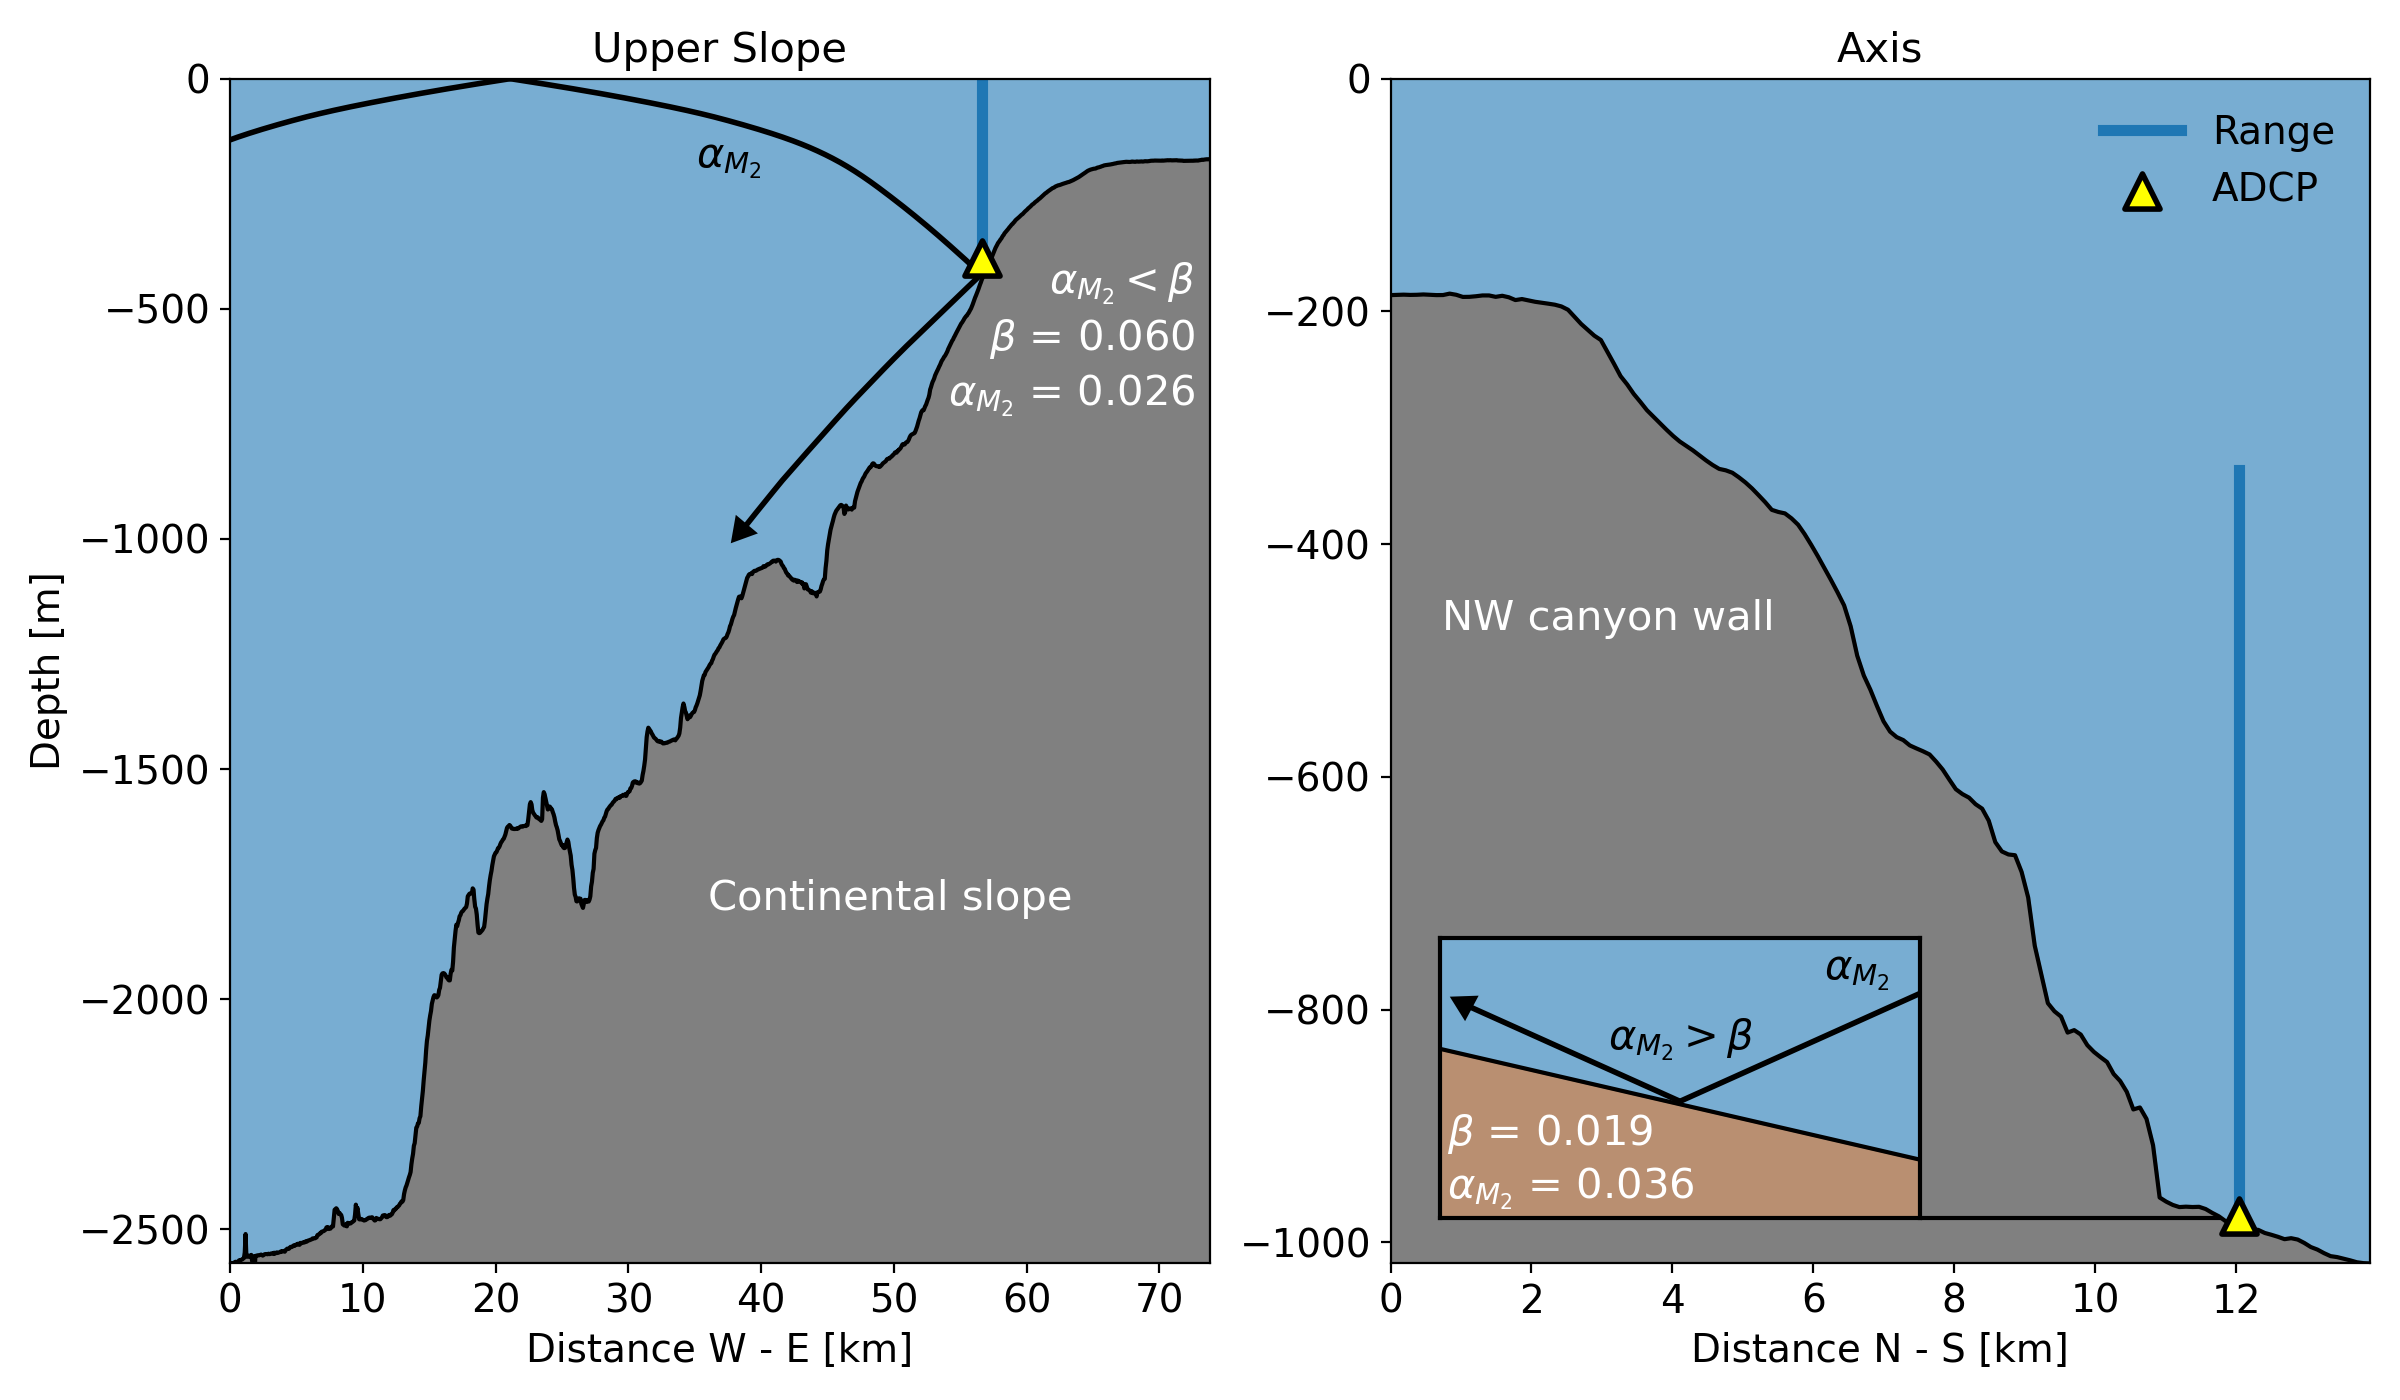

<ipython-input-6-1a636807cd97>:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


In [6]:
# plot local topography cross-sections

# adcp range
range1x = [upper_slope_run_axis[920],upper_slope_run_axis[920]]
range1y = [-379,-3]
range2x = [axis_run_axis[-21],axis_run_axis[-21]]
range2y = [-968,-336]

# ray-tracing (semidiurnal)
ray2x = [upper_slope_run_axis[723],upper_slope_run_axis[888]]
ray2y = [-925,-555]

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(12,7))
fig.subplots_adjust(wspace=0.18)

ax0.plot(upper_slope_run_axis,upper_slope_critical,color='black',label='_nolegend_')
ax0.set_title('Upper Slope',fontsize=15)
ax0.set_xlabel('Distance W - E [km]',fontsize=14)
ax0.set_ylabel('Depth [m]',fontsize=14)
fig.text(0.412, 0.75, fr'$\beta$ = ''{:.3f}'.format(upper_slope_beta),fontsize=15,color='white')
fig.text(0.437, 0.79,r'$\alpha_{M_{2}} < \beta$',fontsize=15,color='white')
fig.text(0.29, 0.88,r'$\alpha_{M_{2}}$',fontsize=15,color='black')
fig.text(0.395, 0.71,r'$\alpha_{M_{2}}$ = 0.026',fontsize=15,color='white')
ax0.set_xlim(0,upper_slope_axis_km)
ax0.set_ylim(upper_slope_critical[0],0)
ax0.tick_params(labelsize=14)
ax0.fill_between(upper_slope_run_axis,upper_slope_critical,alpha=0.6)
ax0.fill_between(upper_slope_run_axis,upper_slope_critical,y2=upper_slope_critical[0],color='grey')
ax0.scatter(upper_slope_run_axis[920],upper_slope_critical[932],color='yellow',s=160,marker='^',linewidths=2,\
            edgecolors='black',zorder=4,label='_nolegend_')
fig.text(0.295, 0.35,'Continental slope',color='white',fontsize=15)
ax0.plot(range1x,range1y,lw=4)
rx = 425
ax0.plot(-xpath[:rx]+21.1,N2_depth[:rx],color='black',lw=2)
ax0.plot(xpath[:rx]+21.1,N2_depth[:rx],color='black',lw=2)
ax0.plot(-xpath[rx:]+(21.1+(2*xpath[rx])),N2_depth[rx:],color='black',lw=2)
ax0.plot(upper_slope_run_axis[625], -980, marker=(3, 0, 140), markersize=10, color='black',linestyle='None')

ax1.plot(axis_run_axis,axis_critical,color='black',label='_nolegend_')
ax1.set_title('Axis',fontsize=15)
ax1.set_xlabel('Distance N - S [km]',fontsize=14)
ax1.set_xlim(0,axis_axis_km)
ax1.set_ylim(axis_critical[-1],0)
ax1.tick_params(labelsize=14)
ax1.fill_between(axis_run_axis,axis_critical,alpha=0.6)
ax1.fill_between(axis_run_axis,axis_critical,y2=axis_critical[-1],color='grey')
ax1.scatter(axis_run_axis[-21],axis_critical[-24],color='yellow',s=160,marker='^',linewidths=2,\
            edgecolors='black',zorder=4,label='ADCP')
fig.text(0.601, 0.55,r'NW canyon wall',color='white',fontsize=15)
#fig.text(0.64, 0.52,r'($\alpha < \beta$)',fontsize=15,color='white')
ax1.plot(range2x,range2y,lw=4,label='Range')
ax1.plot([axis_run_axis[81],axis_run_axis[126]],[-979,-979],color='black')
ax1.legend(fontsize=14,frameon=False)

ax3 = plt.axes([0.6,0.13,0.2,0.2])
ax3.axes.get_xaxis().set_ticks([])
ax3.axes.get_yaxis().set_ticks([])
ax3.plot([0,1],[0.039,0.02],color='black')
fig.text(0.603, 0.182, fr'$\beta$ = ''{:.3f}'.format(axis_beta),fontsize=15,color='white')
fig.text(0.76, 0.3, r'$\alpha_{M_{2}}$',fontsize=15,color='black')
fig.text(0.603, 0.144, r'$\alpha_{M_{2}}$ = 0.036',fontsize=15,color='white')
fig.text(0.67, 0.25,r'$\alpha_{M_{2}} > \beta$',fontsize=15,color='black')
ax3.plot([0.5,1],[0.03,0.0485],lw=2,color='black')
ax3.plot([0.05,0.5],[0.04665,0.03],lw=2,color='black')
ax3.plot(0.05,0.04665, marker=(3, 0, 62), markersize=10, color='black',linestyle='None')
ax3.set_xlim(0,1)
ax3.set_ylim(0.01,0.058)
ax3.fill_between([0,1],[0.039,0.02],color='saddlebrown',alpha=0.6)
ax3.fill_between([0,1],[0.039,0.02],y2=0.058,alpha=0.6)
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(1.5)

fig.tight_layout()
plt.show()

plt.savefig(fname='./topography.pdf',format='pdf')

## Bathymetry

In [7]:
# define plotting region

lon = np.array(ds.lon.values[13490:13930])           # set desired region using lat and lon
lat = np.array(ds.lat.values[210:480])
elev = np.array(ds.Band1.values[210:480,13490:13930])

slope_lat = 48.427                                   # set specific coordinates for ADCP
slope_lon = -126.174
axis_lat = 48.317
axis_lon = -126.050

line_y = np.array([slope_lat-0.0025,axis_lat-0.003])  # set coordinates for distance line
line_x = np.array([slope_lon+0.000,axis_lon-0.001])

In [8]:
# plot bathymetry

# fig, ax = plt.subplots(1,1,figsize=(10.5,9))

# levels = 20       # set contour parameters for visual clarity and adjust colorbar
# vmin = -1400
# vmax = -200
# ticks = np.arange(vmin,vmax+1,100)
# level_boundaries = np.arange(vmin,vmax+1,levels)

# im = ax.contourf(lon,lat,elev,levels=level_boundaries,vmin=vmin,vmax=vmax,extend='both',cmap='cmo.deep_r')
# cbar = fig.colorbar(im,fraction=0.05,aspect=60,pad=0.01,ticks=ticks)
# cbar.ax.tick_params(labelsize=14)
# im1 = ax.contour(lon,lat,elev,levels=ticks,colors='black',linewidths=0.5,linestyles='solid',alpha=0.4)
# ax.set_xlabel('Longitude [$\degree$]',fontsize=14)
# ax.set_ylabel('Latitude [$\degree$]',fontsize=14)
# fig.text(0.98, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)

# ax.plot(line_x,line_y,color='black',lw=1.5,ls='--')
# ax.plot([-125.96,-126.206],[48.423,48.423],color='tab:red',lw=2,ls='--')
# ax.plot(-126.205,48.423, marker=(3, 0, 90), markersize=8, color='tab:red',linestyle='None')
# ax.arrow(slope_lon+0.002,slope_lat-0.0035,-0.0055,0.00866,color='black',width=0.001,head_width=0.003,head_length=0.003)
# ax.arrow(slope_lon+0.003,slope_lat-0.0020,0.011,0.004,color='black',width=0.0009,head_width=0.0025,head_length=0.003)
# ax.arrow(axis_lon+0.003,axis_lat-0.003,0.012,0,color='black',width=0.0008,head_width=0.0025,head_length=0.003)
# ax.arrow(axis_lon+0.002,axis_lat-0.004,0,0.0097,color='black',width=0.0011,head_width=0.0025,head_length=0.003)
# ax.text(-126.15,48.427,'Upper Slope 75 kHz ADCP',fontsize=15)
# ax.text(-126.043,48.318,'Axis 75 & 55 kHz ADCP',fontsize=15)
# ax.text(-126.110,48.371,'15 km',fontsize=15)
# ax.scatter(slope_lon+0.002,slope_lat-0.003,color='gold',s=160,marker='^',linewidths=2,edgecolors='black',zorder=3)
# ax.scatter(axis_lon,axis_lat-0.003,color='gold',s=180,marker='^',linewidths=2,edgecolors='black',zorder=3)
# ax.plot([-126.050,-126.050],[48.299999,48.416],color='tab:red',lw=2,ls='--')
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# ax.clabel(im1, ticks, inline=True, fontsize=12, fmt = '%.f')
# ax.tick_params(labelsize=14)

# fig.tight_layout()
# plt.show()

#plt.savefig(fname='./bathymetry.pdf',format='pdf')

## Criticality

In [9]:
# get distance information

diag = 36.78          # diagonal distance in km
latd = 24.92          # distance top to bottom
lond = 27.04          # average distance side to side
latn = lat.size       # number of latitude points
lonn = lon.size       # number of longitude points
latnd = latd / latn   # km/point
lonnd = lond / lonn   # km/point
latm = latnd * 1000   # m/point
lonm = lonnd * 1000   # m/point

In [10]:
# get elevation gradient magnitudes

elev_grad = np.gradient(elev,latm,lonm)    # gradient of elevation for x and y
elev_grad_mag = np.sqrt((elev_grad[0]**2) + (elev_grad[1]**2)) # magnitude of gradient

# criticality parameters

rows = elev.shape[0]   # number of y points
cols = elev.shape[1]   # number of x points
mindepth = int(np.min(elev))    # lowest depth
deepalpha = np.full(658,alpha[-1])   # extend lower alpha to lowest depth
alphaM2 = np.append(alpha,deepalpha)    # append alpha list with new low depth values
critM2 = np.empty(elev.shape,dtype='float')    # empty array for criticality values

In [11]:
# get M2 criticality based on depth

for i in range(rows):
    for j in range(cols):
        depth = -(int(elev[i,j])) 
        depth_alpha = alphaM2[depth]
        critM2[i,j] = elev_grad_mag[i,j] / depth_alpha

<IPython.core.display.Javascript object>


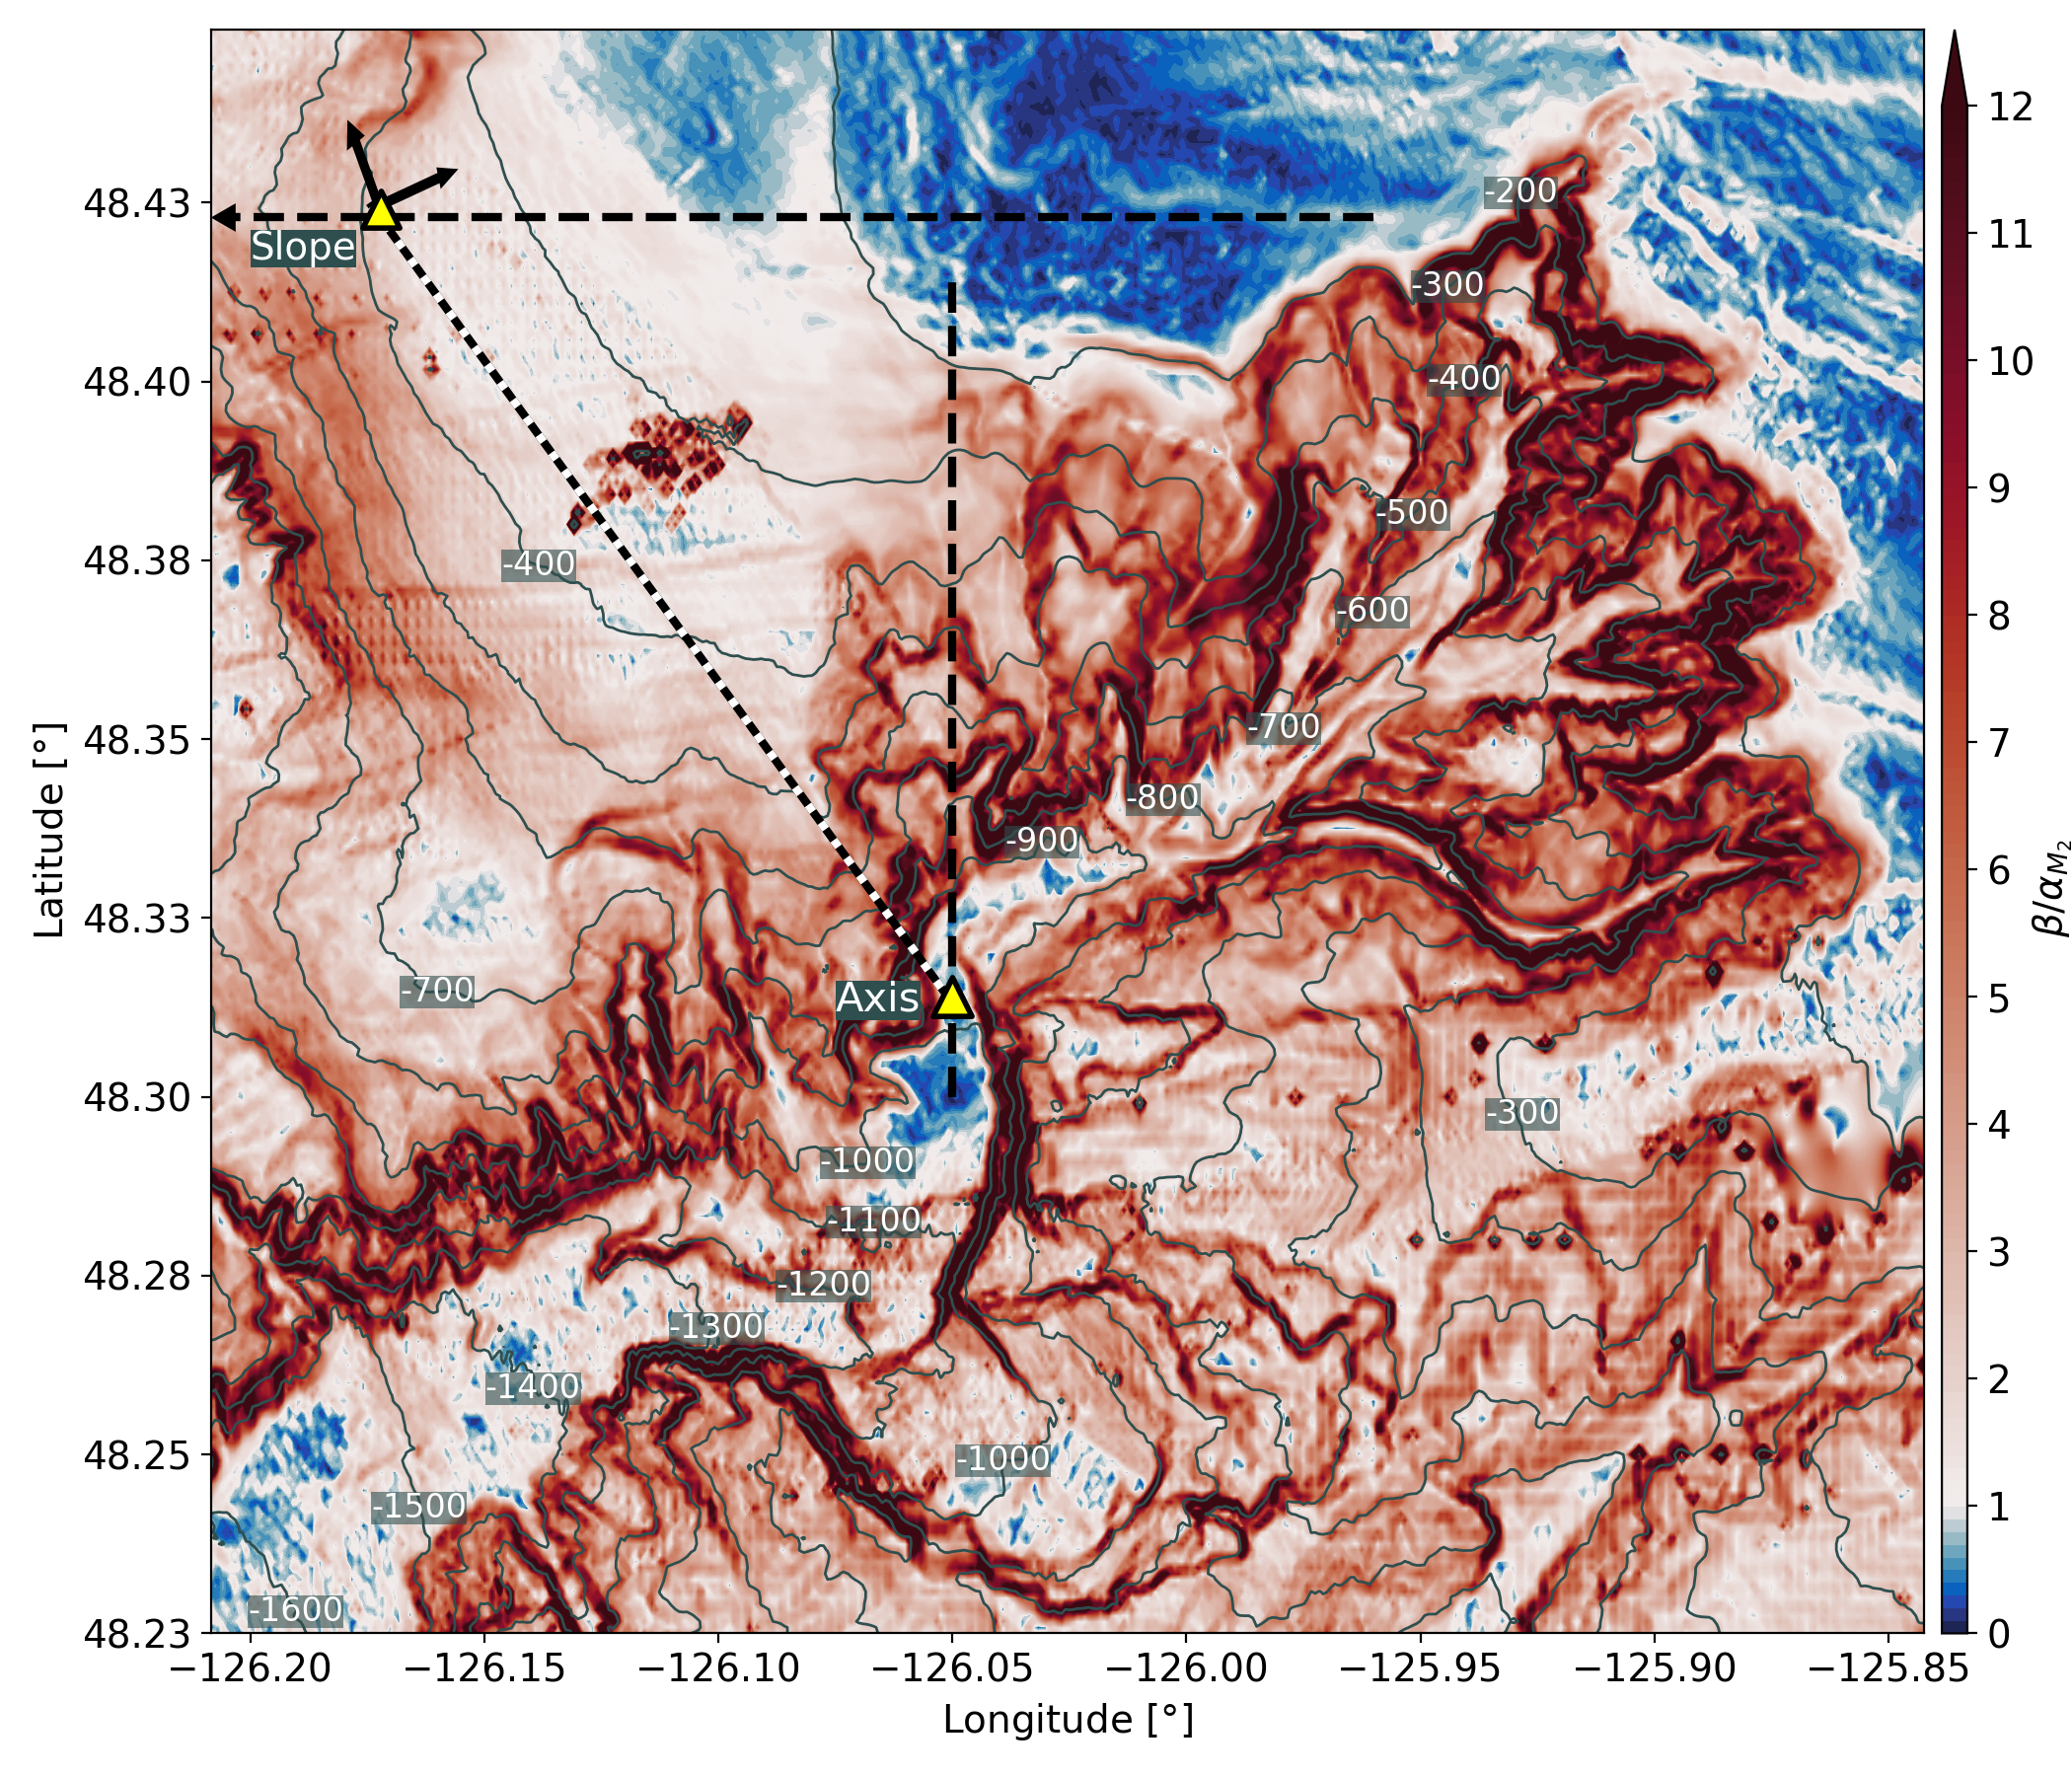

In [24]:
# plot criticality

fig, ax = plt.subplots(1,1,figsize=(10.5,9))

levels = 0.1       # set contour parameters for visual clarity and adjust colorbar
vmin = 0
vmax = 12
ticks = np.arange(vmin,vmax+1,1) # colorbar tick numbers
im1_levels = np.arange(-1600,-100,100)
level_boundaries = np.arange(vmin,vmax+0.1,levels)

norm = colors.TwoSlopeNorm(vmin=vmin,vcenter=1,vmax=vmax)
im = ax.contourf(lon,lat,critM2,levels=level_boundaries,vmin=vmin,vmax=vmax,norm=norm,extend='max',cmap='cmo.balance')
cbar = fig.colorbar(im,fraction=0.05,aspect=60,pad=0.01,ticks=ticks)
cbar.ax.tick_params(labelsize=14)
for c in im.collections:
    c.set_rasterized(True)
im1 = ax.contour(lon,lat,elev,levels=im1_levels,colors='darkslategrey',linewidths=1,linestyles='solid',alpha=1)
for d in im1.collections:
    d.set_rasterized(True)
ax.set_xlabel('Longitude [$\degree$]',fontsize=14)
ax.set_ylabel('Latitude [$\degree$]',fontsize=14)
fig.text(0.98, 0.5, r'$\beta/\alpha_{M_2}$', va='center', rotation='vertical',fontsize=14)
manual_set = [(-125.93,48.427),(-125.945,48.415),(-125.94,48.40),(-125.95,48.38),(-125.96,48.365),(-125.98,48.35),
             (-126.005,48.34),(-126.03,48.335),(-126.06,48.29),(-126.065,48.285),(-126.077,48.275),(-126.10,48.268),
              (-126.144,48.258),(-126.18,48.24),(-126.19,48.228),(-126.14,48.37),(-126.16,48.31),(-125.92,48.3),(-126.04,48.25)]
clabels = ax.clabel(im1, im1_levels, inline=False, fontsize=12, colors='white', fmt = '%.f', manual=manual_set)
[txt.set_backgroundcolor('darkslategrey') for txt in clabels]
[txt.set_bbox(dict(facecolor='darkslategrey', edgecolor='none', pad=0, alpha=0.6)) for txt in clabels]
for l in clabels:
    l.set_rotation(0)

ax.plot(line_x,line_y,color='black',lw=3,ls='solid')
ax.plot(line_x,line_y,color='white',lw=3,ls='dotted')
ax.plot([-125.96,-126.206],[48.423,48.423],color='black',lw=3,ls='--')
#ax.plot([-125.96,-126.206],[48.423,48.423],color='yellow',lw=3,ls='dotted')
ax.plot([-126.050,-126.050],[48.299999,48.415],color='black',lw=3,ls='--')
#ax.plot([-126.050,-126.050],[48.299999,48.416],color='yellow',lw=3,ls='dotted')
ax.plot(-126.205,48.423, marker=(3, 0, 90), markersize=10, color='black',linestyle='None')

ax.arrow(slope_lon+0.002,slope_lat-0.0035,-0.0055,0.010,color='black',width=0.0013,head_width=0.0035,head_length=0.003,zorder=5)
ax.arrow(slope_lon+0.003,slope_lat-0.0020,0.0115,0.0035,color='black',width=0.0011,head_width=0.0025,head_length=0.0035,zorder=5)
#ax.arrow(axis_lon+0.003,axis_lat-0.003,0.012,0,color='black',width=0.0008,head_width=0.0025,head_length=0.003,zorder=5)
#ax.arrow(axis_lon+0.002,axis_lat-0.004,0,0.0097,color='black',width=0.0011,head_width=0.0025,head_length=0.003,zorder=5)

ax.text(-126.20,48.417,'Slope',fontsize=14,color='white',backgroundcolor='darkslategrey',
        bbox=dict(facecolor='darkslategrey', edgecolor='none', pad=0, alpha=1))
ax.text(-126.075,48.312,'Axis',fontsize=15,color='white',backgroundcolor='darkslategrey',
        bbox=dict(facecolor='darkslategrey', edgecolor='none', pad=0, alpha=1))
#ax.text(-126.125,48.386,'15 km',fontsize=14,color='white',backgroundcolor='darkslategrey',
#        bbox=dict(facecolor='darkslategrey', edgecolor='none', pad=0, alpha=0.6))
ax.scatter(slope_lon+0.002,slope_lat-0.003,color='yellow',s=180,marker='^',linewidths=2,edgecolors='black',zorder=6)
ax.scatter(axis_lon,axis_lat-0.003,color='yellow',s=200,marker='^',linewidths=2,edgecolors='black',zorder=6)

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.tick_params(labelsize=14)

fig.tight_layout()
plt.show()

plt.savefig(fname='./criticality_M2_lowres.pdf',format='pdf',dpi=25)
plt.savefig(fname='./criticality_M2_highres.pdf',format='pdf',dpi=100)